# Bio dataset - 1 optima vs Many

These are just helper classes so we can reuse code

In [ ]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KDTree

class data_reader(object):
    def __init__(self, seed=42):
        data = pd.read_csv('data/toxicity_data.csv')

        train = data[(data['train/test']=='train')].to_numpy()[:,3:].astype(np.float64)
        test = data[(data['train/test']=='test')].to_numpy()[:,3:].astype(np.float64)
        
        test -= np.mean(train, 0)
        test /= np.std(train, 0)
        train -= np.mean(train, 0)
        test /= np.std(train, 0)
        
        # clear out the stuff that cassotti 2014 cuts
        # this is about 30 % of training and 16% of test
        kd_tree = KDTree(train[:,1:])
        train_pass, test_pass = np.ones(len(train), dtype=bool), np.ones(len(test), dtype=bool)
        for i in range(len(train)):
            if np.mean(kd_tree.query(train[i,1:].reshape(1,-1), k=4)[0][0][1:]) > 1.26**8:
                train_pass[i] = False
        #print((len(train_pass)-np.sum(train_pass))/len(train_pass))
        
        train = train[train_pass]
        kd_tree = KDTree(train[:,1:])
        
        for i in range(len(test)):
            if np.mean(kd_tree.query(test[i,1:].reshape(1,-1), k=4)[0][0][1:]) > 1.26**8:
                test_pass[i] = False
        #print((len(test_pass)-np.sum(test_pass))/len(test))
        test = test[test_pass]
    
        self.X_train = train[:,1:]
        self.y_train = train[:,0]
        self.X_test = test[:,1:]
        self.y_test = test[:,0]

    def get_training(self):
        return self.X_train, self.y_train
    
    def get_test(self):
        return self.X_test, self.y_test

In [2]:
data = data_reader()

In [34]:
class evaluator(object):
    def __init__(self, data, seed=42):
        self.data = data
        self.rng = np.random.default_rng(seed)
        
    def R2(self, gp):
        return gp.score(gp.X_train_, gp.y_train_)
    
    def Q2_cv(self, gp, cv_num=5, verbose=False):
        x, y = np.copy(self.data.X_train), np.copy(self.data.y_train)
        shuffle = self.rng.permutation(len(x))
        x, y = x[shuffle], y[shuffle]
        
        chunk_size = int(len(x)/cv_num)
        q2 = np.empty(cv_num)

        for i in range(cv_num):
            train_x = np.append(x[:chunk_size*i],x[chunk_size*(i+1):],0)
            train_y = np.append(y[:chunk_size*i],y[chunk_size*(i+1):])

            test_x = x[chunk_size*i:chunk_size*(i+1)]
            test_y = y[chunk_size*i:chunk_size*(i+1)]
            
            n_ext = len(test_x)
            n_tr = len(train_x)
            mean_tr = np.mean(train_y)
            newGP = GaussianProcessRegressor(alpha=gp.alpha, kernel=gp.kernel_, optimizer=None)
            newGP.fit(train_x, train_y)
            y_pred = newGP.predict(test_x)

            press = np.sum(np.power(y_pred-test_y,2))
            tss = np.sum(np.power(train_y-mean_tr,2))

            q2[i] = 1. - (press/n_ext) / (tss/n_tr)

        if verbose: print(q2)
        return np.mean(q2)
    
    def Q2_ext(self, gp):
        n_ext = len(self.data.X_test)
        n_tr = len(self.data.X_train)
        mean_tr = np.mean(self.data.y_train)
        y_pred = gp.predict(self.data.X_test)
        
        press = np.sum(np.power(y_pred-self.data.y_test,2))
        tss = np.sum(np.power(self.data.y_train-mean_tr,2))
        
        return 1. - (press/n_ext) / (tss/n_tr)
    
    
    def empirical_error(self, gp):
        
        y_pred, y_cov = gp.predict(self.data.X_test, return_cov=True)
        y_std = np.sqrt(np.diag(y_cov))
        residual = self.data.y_test-y_pred

        # percentages within x sigma from wikipedia
        true_remain = 1.-np.array([
        0.382924922548026,
        0.682689492137086,
        0.866385597462284,
        0.954499736103642,
        0.987580669348448,
        0.997300203936740,
        0.999534741841929,
        0.999936657516334,
        0.999993204653751,
        0.999999426696856,
        0.999999962020875,
        0.999999998026825,
        0.999999999919680,
        ])

        print('empircal error checks...')
        for i in range(1,6):
            within = np.logical_and(
                self.data.y_test-i*y_std<=y_pred, 
                y_pred<=self.data.y_test+i*y_std)
            perc_out = (1.-np.sum(within)/len(within)).round(4)
            print(perc_out,'% are beyond',i,'sigma, while there should be',true_remain[i-1].round(4),'%')
            print('this comes from ',len(y_std)-np.sum(within),'outlier(s)\n')
            

Load up the data. For our purposes, this is an 8 dimensional regression problem

In [35]:
tester = evaluator(data)

In [4]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, Matern

"""
https://archive.ics.uci.edu/ml/datasets/QSAR+aquatic+toxicity

1) TPSA(Tot)
2) SAacc
3) H-050
4) MLOGP
5) RDCHI
6) GATS1p
7) nN
8) C-040
9) quantitative response, LC50 [-LOG(mol/L)]

""";

## Sklearn with only one fitting method

In [6]:
kernel = 1.**2 * Matern(length_scale=.1*np.ones(8),nu=2.0)\
            + 0.1**2 * WhiteKernel(noise_level=1.)

In [7]:
sklearn_gpr = GaussianProcessRegressor(kernel=kernel,
                                  alpha=1e-5, 
                                  optimizer='fmin_l_bfgs_b', 
                                  n_restarts_optimizer=5, 
                                  normalize_y=False, 
                                  copy_X_train=True, 
                                  random_state=42)

In [8]:
x, y = data.get_training()
sklearn_gpr = sklearn_gpr.fit(x,y)

In [9]:
tester.R2(sklearn_gpr)

0.9294222194730939

### Cross validation scores

In [10]:
tester.Q2_cv(sklearn_gpr)

[0.5272964  0.67937215 0.74914004 0.73079947 0.46614746]


0.6305511031497929

### Test Score

In [11]:
tester.Q2_ext(sklearn_gpr)

0.8785047172407496

This is a pretty ok score. Let's check if the errors are accurate and what the residuals look like

In [12]:
tester.empirical_error(sklearn_gpr)

empircal error checks...
0.0 % are beyond 1 sigma, while there should be 0.6171 %
this comes from  0 outlier(s)

0.0 % are beyond 2 sigma, while there should be 0.3173 %
this comes from  0 outlier(s)

0.0 % are beyond 3 sigma, while there should be 0.1336 %
this comes from  0 outlier(s)

0.0 % are beyond 4 sigma, while there should be 0.0455 %
this comes from  0 outlier(s)

0.0 % are beyond 5 sigma, while there should be 0.0124 %
this comes from  0 outlier(s)



So from this it looks like the errors are pretty big - it covers 100% of the data in 1 sigma, when it should be roughly 2/3. 

In [13]:
x, y = data.get_test()

In [14]:
y_pred, y_cov = sklearn_gpr.predict(x, return_cov=True)

In [15]:
y_err = np.sqrt(np.diag(y_cov))

In [16]:
useless = np.arange(len(x))

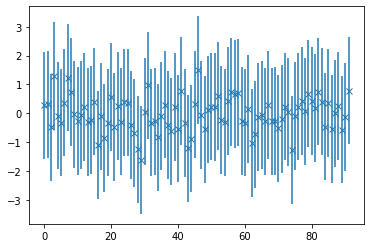

In [17]:
plt.errorbar(useless, y_pred-y, yerr=y_err, fmt='x');

So we can see that this is what's happening. The errors are quite large

## Sklearn with many models given by HGDL

In [23]:
# this overwrites GaussianProcessRegressor's fit to use HGDL and 
#  return a list of Gaussian Processes
from fit import fit
GaussianProcessRegressor.fit = fit

In [24]:
GPs = GaussianProcessRegressor(kernel=kernel,
                              alpha=1e-5,
                              optimizer='hgdl',
                              random_state=42).fit(x,y)

In [25]:
GPs = sorted(GPs, key=lambda x: x.log_marginal_likelihood_value_)

In [27]:
GPs

[GaussianProcessRegressor(alpha=1e-05,
                          kernel=0.555**2 * Matern(length_scale=[6.99e-05, 0.144, 2.61e-05, 0.871, 0.0459, 0.000279, 0.000108, 7.52], nu=2) + 0.00928**2 * WhiteKernel(noise_level=354),
                          random_state=42),
 GaussianProcessRegressor(alpha=1e-05,
                          kernel=0.582**2 * Matern(length_scale=[0.011, 2.03e-05, 0.233, 0.0014, 0.0316, 3.42e+03, 0.00218, 3.83e-05], nu=2) + 0.0808**2 * WhiteKernel(noise_level=0.00865),
                          random_state=42),
 GaussianProcessRegressor(alpha=1e-05,
                          kernel=0.294**2 * Matern(length_scale=[67.3, 2.3e+03, 0.00456, 3.48e+04, 1.13, 3.5e+04, 9.94e+04, 0.00528], nu=2) + 0.0695**2 * WhiteKernel(noise_level=50.4),
                          random_state=42),
 GaussianProcessRegressor(alpha=1e-05,
                          kernel=0.576**2 * Matern(length_scale=[0.000382, 8.05, 1.69e-05, 3.56e+04, 1.38, 6.46e+03, 6.72e-05, 388], nu=2) + 0.111**2 * W

In [37]:
for i in range(len(GPs)):
    print('\n\ngp:',i+1)
    print('cross validation scores:')

    print('R2',tester.R2(GPs[i]).round(3))
    print('Q2_ext',tester.Q2_cv(GPs[i]).round(3))



gp: 1
cross validation scores:
R2 0.991
Q2_ext 0.077


gp: 2
cross validation scores:
R2 1.0
Q2_ext 0.064


gp: 3
cross validation scores:
R2 0.364
Q2_ext 0.402


gp: 4
cross validation scores:
R2 0.935
Q2_ext 0.534


gp: 5
cross validation scores:
R2 0.98
Q2_ext 0.543


In [12]:
tester.empirical_error(sklearn_gpr)

empircal error checks...
0.0 % are beyond 1 sigma, while there should be 0.6171 %
this comes from  0 outlier(s)

0.0 % are beyond 2 sigma, while there should be 0.3173 %
this comes from  0 outlier(s)

0.0 % are beyond 3 sigma, while there should be 0.1336 %
this comes from  0 outlier(s)

0.0 % are beyond 4 sigma, while there should be 0.0455 %
this comes from  0 outlier(s)

0.0 % are beyond 5 sigma, while there should be 0.0124 %
this comes from  0 outlier(s)



So from this it looks like the errors are pretty big - it covers 100% of the data in 1 sigma, when it should be roughly 2/3. 

In [13]:
x, y = data.get_test()

In [14]:
y_pred, y_cov = sklearn_gpr.predict(x, return_cov=True)

In [15]:
y_err = np.sqrt(np.diag(y_cov))

In [16]:
useless = np.arange(len(x))

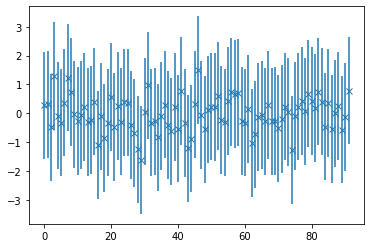

In [17]:
plt.errorbar(useless, y_pred-y, yerr=y_err, fmt='x');

In [15]:
kernel = 1.**2 * Matern(length_scale=.1*np.ones(x.shape[1]),nu=2.0)\
            + 0.1**2 * Matern(length_scale=.1*np.ones(x.shape[1]),nu=2) * WhiteKernel(noise_level=1.)

In [16]:
sklearn_gpr = GaussianProcessRegressor(kernel=kernel,
                                  alpha=1e-5, 
                                  optimizer='fmin_l_bfgs_b', 
                                  n_restarts_optimizer=5, 
                                  normalize_y=False, 
                                  copy_X_train=True, 
                                  random_state=42)

### Cross validation scores

In [17]:
chunk = int(len(x)/5)
f1, f2, f3 = 0, 0, 0

for i in range(5):
    # get the training data for that cross validation split
    x_train = np.append(x[:chunk*i],x[chunk*(i+1):],0)
    y_train = np.append(y[:chunk*i],y[chunk*(i+1):],0)
    x_test = x[chunk*i:chunk*(i+1)]
    y_test = y[chunk*i:chunk*(i+1)]
    # train
    sklearn_gpr.fit(x_train, y_train)
    # evaluate

    press = np.sum(np.power(y_test-sklearn_gpr.predict(x_test),2))
    ss_tr = np.sum(np.power(y_test-np.mean(y_train),2))
    ss_ext = np.sum(np.power(y_test-np.mean(y_test),2))
    tss = np.sum(np.power(y_train-np.mean(y_train),2))
    tmp1 = 1. - press/ss_tr
    tmp2 = 1. - press/ss_ext
    tmp3 = 1. - press * x_train.shape[1] / (tss*x_test.shape[1])
#     print('scores this round:')
#     for f in ['tmp1','tmp2','tmp3']:
#         print(f,':', eval(f).round(2))
    f1, f2, f3 = f1+tmp1/5., f2+tmp2/5., f3+tmp3/5.
for f in ['f1','f2','f3']:
    print(f,':', eval(f).round(2))

f1 : 0.49
f2 : 0.48
f3 : 0.87


So we can see that sklearn performs seemingly pretty well on this dataset. I have already tuned the initial parameters to get good scores on the cross validation

### Test scores

In [18]:
sklearn_gpr = sklearn_gpr.fit(x,y)

In [19]:
sklearn_gpr.log_marginal_likelihood_value_

-440.9116862185076

In [20]:
sklearn_gpr.kernel_

0.954**2 * Matern(length_scale=[0.458, 1.19, 1.55, 1.59, 1.09, 4.21, 0.896, 0.1], nu=2) + 0.224**2 * Matern(length_scale=[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], nu=2) * WhiteKernel(noise_level=2.84)

train ---------------------------------------


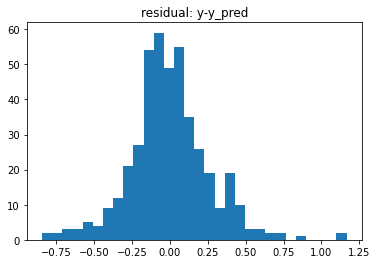

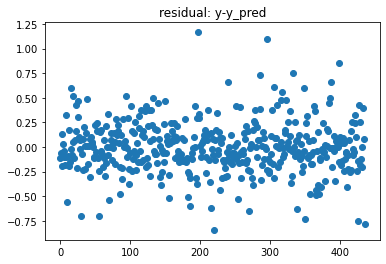

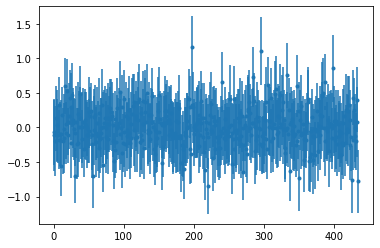

calculating percentage covered when 1,2,3,&4 sigma away
sigma: 1 0.911
sigma: 2 0.993
sigma: 3 1.0
sigma: 4 1.0
test ---------------------------------------


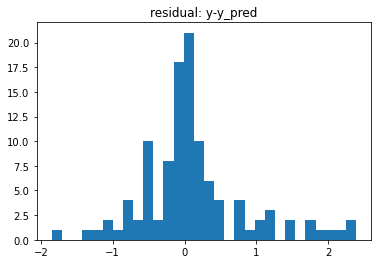

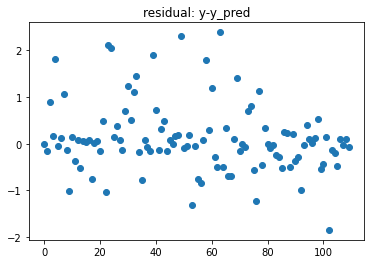

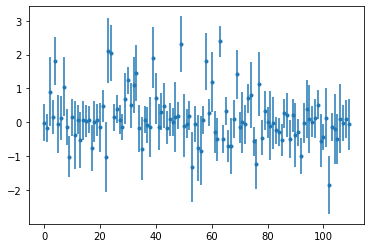

calculating percentage covered when 1,2,3,&4 sigma away
sigma: 1 0.736
sigma: 2 0.918
sigma: 3 0.982
sigma: 4 0.991
f1 : 0.55
f2 : 0.54
f3 : 0.86


In [21]:
data.info(sklearn_gpr)